# Real estate price regression with XGBoost

A more detailed analysis following the preliminaries. Let's increase the accuracy of our model by including more information:

1. use one-hot encoding on zipcode
2. use PCA to reduce the dimensionality of zipcode categories
3. include year and date information

In [18]:
import time
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import explained_variance_score
from sklearn.decomposition import PCA

import xgboost

In [19]:
# load the csv file into a pandas dataframe
dat = pd.read_csv('kc_house_data.csv')

as is, the zipcode column is not usable. however, there are only 70 unique zipcodes, so the goal here is to tranform those data into categorical data.

In [20]:
print(dat.zipcode.unique())
print('rows: {}'.format(len(dat)))
print('unique zipcodes: {}'.format(len(dat.zipcode.unique())))

[98178 98125 98028 98136 98074 98053 98003 98198 98146 98038 98007 98115
 98107 98126 98019 98103 98002 98133 98040 98092 98030 98119 98112 98052
 98027 98117 98058 98001 98056 98166 98023 98070 98148 98105 98042 98008
 98059 98122 98144 98004 98005 98034 98075 98116 98010 98118 98199 98032
 98045 98102 98077 98108 98168 98177 98065 98029 98006 98109 98022 98033
 98155 98024 98011 98031 98106 98072 98188 98014 98055 98039]
rows: 21613
unique zipcodes: 70


## Transform zipcode with one-hot encoding

In [21]:
# relabel zipcodes by integers [0, 70]
label_encoder = preprocessing.LabelEncoder()
zip_labels = label_encoder.fit_transform(dat['zipcode'])

# one-hot encode the integer labels
onehot_encoder = preprocessing.OneHotEncoder()
onehot_encoder.fit(zip_labels.reshape(-1, 1))

# get the matrix of zip categories
onehot_labels = onehot_encoder.transform(zip_labels.reshape(-1, 1)).toarray()

# check that every row has one and only one categorical label
all([sum(onehot_labels[i])==1 for i in range(len(onehot_labels))])

True

In [22]:
# generate a dataframe of the one-hot encoded zip categories
zip_column_names = ['zip{}'.format(i) for i in range(onehot_labels.shape[1])]
zip_pd = pd.DataFrame(data=onehot_labels, 
                     columns=zip_column_names)

# we will store the transformed dataset as dat_2
# join the two dataframes and drop the old zipcode column
dat_2 = dat.join(zip_pd)
dat_2 = dat_2.drop(labels='zipcode', axis=1)
dat_2.to_csv('dat_2.csv')
dat_2.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zip60,zip61,zip62,zip63,zip64,zip65,zip66,zip67,zip68,zip69
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### XGBoost with one-hot zipcode data

In [159]:
def score_xgb(dat, feature_columns):
    # xgboost regressor
#     xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08,
#                            gamma=0, subsample=0.75, 
#                            colsample_bytree=1, max_depth=7)
    xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.05,
                               gamma=0, subsample=0.70, 
                               colsample_bytree=0.7, max_depth=15)
    
    # target is real estate price
    target = dat.price
    features = dat[feature_columns]
    
    # split into train and test sets
    features_train, features_test, target_train, target_test =\
    model_selection.train_test_split(features.values, target.values, test_size=0.33)

    # perform fit and evaluate performance
    xgb.fit(features_train, target_train)
    predictions = xgb.predict(features_test)
    return explained_variance_score(predictions, target_test)

In [109]:
# features found to be useful
feature_columns_2 = ['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','lat','waterfront','yr_built','bedrooms']

# add the zip code columns
feature_columns_2 += zip_column_names

# evaluate the regression on the transformed dataset
score_xgb(dat_2, feature_columns_2)

0.8387932265062801

## Dimensionality reduction

70 new columns is a bit much. Let's use PCA to reduce the dimensions.

TODO: FeatureAgglomeration

In [29]:
# reduce to 10 columns
n_components=10

# perform PCA on zipcode labels
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(zip_pd)

# create new dataframe of principal component data
pca_labels = ['pc{}'.format(i) for i in range(n_components)]
pca_pd = pd.DataFrame(data=principal_components, 
                      columns=pca_labels)

# we will store a new transformed dataset as dat_3
# join the two dataframes and drop the old zipcode column
dat_3 = dat.join(pca_pd)
dat_3 = dat_3.drop(labels='zipcode', axis=1)
dat_3.to_csv('dat_3.csv')
dat_3.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,-0.030083,-0.006049,-0.010159,0.024086,0.018099,-0.007116,-0.023477,0.018869,-0.006561,-0.003304
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,-0.080037,-0.043093,-0.037604,0.121337,-0.008207,0.016801,-0.129863,-0.040887,0.068935,-0.062577
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,-0.023566,-0.030813,-0.011655,0.042911,0.007715,-0.010158,-0.033904,-0.003769,0.002173,-0.063861
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,-0.032066,-0.006879,-0.012488,0.048143,0.005695,-0.019294,0.005906,0.023425,0.019163,0.011165
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,-0.019928,-0.038341,0.020576,-0.054592,-0.002977,-0.156404,0.056114,-0.084391,0.041354,0.131443


Evaluate the transformed dataset

In [30]:
# features found to be useful
feature_columns_3 = ['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','lat','waterfront','yr_built','bedrooms']

# add the zip code columns
feature_columns_3 += pca_labels

# evaluate the regression on the transformed dataset
score_xgb(dat_3, feature_columns_3)

0.8746367100794001

Did the dimensionality reduction give us a performance boost?

In [31]:
def model_time(dat, features):
    start = time.time()
    score_xgb(dat, features)
    end = time.time()
    print('time required: {}'.format(end - start))

In [32]:
print('{} columns \r'.format(dat_3.shape[1]))
model_time(dat_3, feature_columns_3)
print('{} columns \r'.format(dat_2.shape[1]))
model_time(dat_2, feature_columns_2)

30 columns 
time required: 3.060359001159668
90 columns 
time required: 8.93336296081543


## Date information

We've excluded the date column, which includes year information which should be useful.

Why stop with years though? We could fine-grain it by days since the earliest date.

I expect there would be variations on each scale, so let's try a few features:

* absolute_time
* day_of_year
* day_of_week
* month_of_year
* hour_of_day
* minute_of_hour

We will have to change some of these to one-hot encoding.

#### Calculate date objects

In [33]:
date_strings = [d[:8] for d in dat['date']]
dates = [datetime.datetime.strptime(date_string, "%Y%m%d").date() for date_string in date_strings]
dates[:10]

[datetime.date(2014, 10, 13),
 datetime.date(2014, 12, 9),
 datetime.date(2015, 2, 25),
 datetime.date(2014, 12, 9),
 datetime.date(2015, 2, 18),
 datetime.date(2014, 5, 12),
 datetime.date(2014, 6, 27),
 datetime.date(2015, 1, 15),
 datetime.date(2015, 4, 15),
 datetime.date(2015, 3, 12)]

#### Calculate relevant metrics

In [34]:
earliest_date = min(dates)
absolute_day = np.array([(dates[i]-earliest_date).days for i in range(len(dates))])
month_of_year = np.array([dates[i].month for i in range(len(dates))])
day_of_month = np.array([dates[i].day for i in range(len(dates))])
day_of_week = np.array([dates[i].weekday() for i in range(len(dates))])
day_of_year = np.array([dates[i].timetuple().tm_yday for i in range(len(dates))])
year = np.array([dates[i].year for i in range(len(dates))])

date_data = np.column_stack([absolute_day, day_of_week, day_of_month, day_of_year, month_of_year, year])
date_labels = ['absolute_day', 'day_of_week', 'day_of_month', 'day_of_year', 'month_of_year', 'year']
date_pd = pd.DataFrame(data=date_data, columns=date_labels)

In [35]:
dat_4 = dat_3.join(date_pd)
dat_4.to_csv('dat_4.csv')
dat_4.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,pc6,pc7,pc8,pc9,absolute_day,day_of_week,day_of_month,day_of_year,month_of_year,year
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,-0.023477,0.018869,-0.006561,-0.003304,164,0,13,286,10,2014
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,-0.129863,-0.040887,0.068935,-0.062577,221,1,9,343,12,2014
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,-0.033904,-0.003769,0.002173,-0.063861,299,2,25,56,2,2015
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,0.005906,0.023425,0.019163,0.011165,221,1,9,343,12,2014
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,0.056114,-0.084391,0.041354,0.131443,292,2,18,49,2,2015


In [88]:
# one-hot encode day of week, month, and year
onehot_encoder = preprocessing.OneHotEncoder()
onehot_encoder.fit(day_of_week.reshape(-1, 1))
day_labels = onehot_encoder.transform(day_of_week.reshape(-1, 1)).toarray()
day_pd = pd.DataFrame(data=day_labels, columns=['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'])

onehot_encoder.fit(month_of_year.reshape(-1, 1))
month_labels = onehot_encoder.transform(month_of_year.reshape(-1, 1)).toarray()
month_pd = pd.DataFrame(data=month_labels, columns=['jan', 'feb', 'mar', 'apr', 'may', 
                                                  'jun', 'jul', 'aug', 'sep', 'oct', 
                                                  'nov', 'dec'])
onehot_encoder.fit(year.reshape(-1, 1))
year_labels = onehot_encoder.transform(year.reshape(-1, 1)).toarray()
year_pd = pd.DataFrame(data=year_labels, columns=['2014', '2015'])

abs_pd = pd.DataFrame(data=absolute_day, columns=['absolute_day'])
dat_5 = dat_2.join([day_pd, month_pd, year_pd, abs_pd])
dat_5.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,jun,jul,aug,sep,oct,nov,dec,2014,2015,absolute_day
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,164
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,221
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,299
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,221
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,292


In [170]:
# features found to be useful
feature_columns_5 = ['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view', 'sqft_basement', 'lat', 'long', 'waterfront', 'yr_built', 'bedrooms']

# add the zip code columns
feature_columns_5 += zip_column_names
# feature_columns_5 += pca_labels
# feature_columns_5 += ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
feature_columns_5 += ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
feature_columns_5 += ['absolute_day']
# feature_columns_5 += ['2014', '2015']

# evaluate the regression on the transformed dataset
score_xgb(dat_5, feature_columns_5)

0.8687276110039416

In [175]:
# dataset: zipcode PCA
feature_columns_3 = ['sqft_living','grade', 'sqft_above', 'sqft_living15', 'bathrooms','view','sqft_basement','lat', 'long', 'waterfront','yr_built','bedrooms']
feature_columns_3 += pca_labels
score_xgb(dat_3, feature_columns_3)

0.8469308828121839

In [174]:
# dataset: basic
feature_columns_1 = ['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view', 'sqft_basement', 'lat', 'long', 'waterfront', 'yr_built', 'bedrooms', 'zipcode']
score_xgb(dat, feature_columns_1)

0.8583298588752083

####  TODO: tune the model

## Visualization

Let's try to visualize the data in various ways

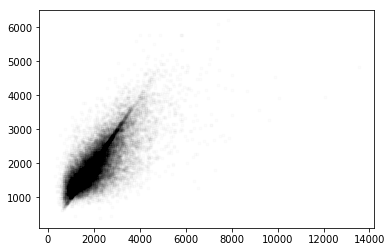

In [140]:
# what is sqft_living15 vs. sqft_living ?

plt.plot(dat.sqft_living, dat.sqft_living15, 'k.', alpha=0.01)
plt.show()

#### TODO: quantify date category effects
it may be hard to see the effect of date information because if it is dwarfed by the other effects

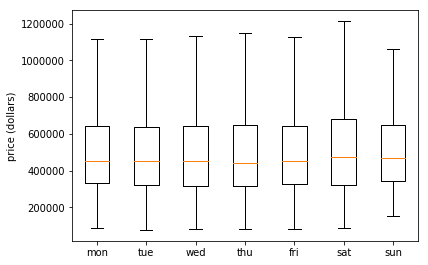

In [36]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
day_prices = []
for i in range(7):
    day_prices.append(dat_4[dat_4.day_of_week == i].price.values)
ax.boxplot(day_prices, showfliers=False)
ax.set_ylabel('price (dollars)')
ax.set_xticklabels(['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'])
plt.show(fig)

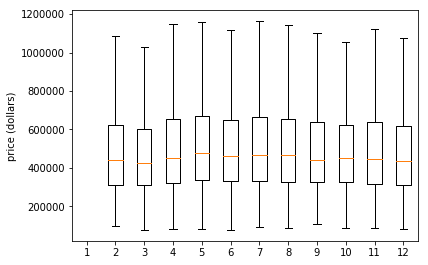

In [37]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
day_prices = []
for i in range(12):
    day_prices.append(dat_4[dat_4.month_of_year == i].price.values)
ax.boxplot(day_prices, showfliers=False)
ax.set_ylabel('price (dollars)')
# ax.set_xticklabels(['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'])
plt.show(fig)

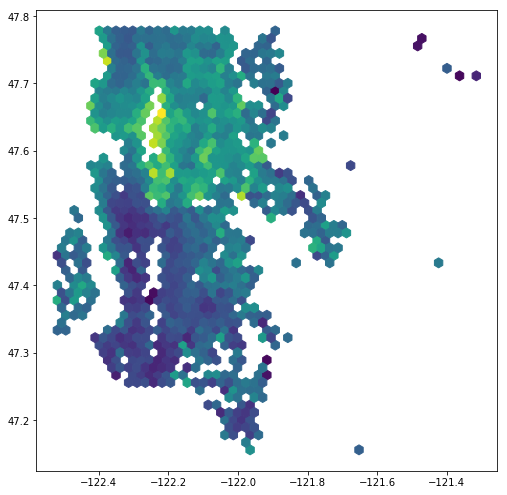

In [169]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.hexbin(dat['long'], dat['lat'], C=dat['price'], bins='log', gridsize=50)
plt.show(fig)

In [181]:
# features found to be useful
feature_columns_5 = ['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms', 'view', 'sqft_basement', 'lat', 'long', 'waterfront', 'yr_built', 'bedrooms']

# evaluate the regression on the transformed dataset
score_xgb(dat, ['bathrooms', 'view','sqft_living', 'grade', 'lat', 'long', 'zipcode'])

0.8217176348340105

In [185]:
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'